# Setup
---


Import python modules

In [2]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
import os
import nasdaqdatalink
import matplotlib.pyplot as plt
import tensorflow as tf
from yahoofinancials import YahooFinancials
from sklearn.base import BaseEstimator
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from dotenv import load_dotenv


2023-09-25 11:19:08.563754: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Configure environment and API key. The key content is left out for security

In [3]:
load_dotenv()

Some global variables

In [4]:
## The foreign currency
ccy = 'EUR'

## The inflation dataset
inf_dataset = 'RATEINF/INFLATION_EUR'

## Comparison matrix
compare = pd.DataFrame({'item': ['Goal','Model','R2-Test', 'Mean Absolute Error','Mean Squared Error','Root Mean Squared Error']})
compare.set_index('item')

""
item
Goal
Model
R2-Test
Mean Absolute Error
Mean Squared Error
Root Mean Squared Error


# Data exploration
---

Downloads data sets and explore the data.

The exchange rate history is going to be our main dataset. 

Besides, certain economic indicators which are often regarded to influence exchange rates are obtained. Including: 

- FED fund rates
- Inflation rates (year on year) of both countries


In [5]:
fed_rates = nasdaqdatalink.get("FED/RIFSPFF_N_D")
fed_rates = fed_rates['2004-01-01':]
print(fed_rates.head())
fed_rates.describe()

            Value
Date             
2004-01-01   0.94
2004-01-02   1.01
2004-01-03   1.01
2004-01-04   1.01
2004-01-05   0.97


,Value
count,7204.000000
mean,1.442708
std,1.727701
min,0.040000
25%,0.120000
50%,0.400000
75%,2.330000
max,5.410000


In [6]:
fccy_inflation_rate = nasdaqdatalink.get(inf_dataset)
fccy_inflation_rate = fccy_inflation_rate['2003-11-30':]
print(fccy_inflation_rate.head())
fccy_inflation_rate.describe()

            Value
Date             
2003-11-30   2.15
2003-12-31   1.97
2004-01-31   1.88
2004-02-29   1.61
2004-03-31   1.67


,Value
count,238.000000
mean,2.096471
std,2.042019
min,-0.650000
25%,0.910000
50%,1.865000
75%,2.467500
max,10.620000


In [7]:
usa_inflation_rate = nasdaqdatalink.get("RATEINF/INFLATION_USA")
usa_inflation_rate = usa_inflation_rate['2003-11-30':]
print(usa_inflation_rate.head())
usa_inflation_rate.describe()

            Value
Date             
2003-11-30  1.765
2003-12-31  1.879
2004-01-31  1.926
2004-02-29  1.693
2004-03-31  1.737


,Value
count,238.000000
mean,2.553702
std,1.950578
min,-2.097000
25%,1.479500
50%,2.135000
75%,3.410500
max,9.060000


In [8]:
ticker = yf.Ticker(ccy+ '=X')
hist = ticker.history(period='max')
hist = hist['2004-01-01':]
hist.rename(columns={'Close':'close', 'Open':'open', 'High':'high', 'Low':'low', 'Volume':'volume'}, inplace=True)
hist.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
hist


,open,high,low,close,volume
Date,,,,,
2004-01-01 00:00:00+00:00,0.79428,0.80167,0.79315,0.79479,0
2004-01-02 00:00:00+00:00,0.79479,0.79828,0.79189,0.79479,0
2004-01-05 00:00:00+00:00,0.79120,0.79133,0.78777,0.78821,0
2004-01-06 00:00:00+00:00,0.78808,0.78914,0.78076,0.78610,0
2004-01-07 00:00:00+00:00,0.78592,0.79208,0.78493,0.79108,0
...,...,...,...,...,...
2023-09-19 00:00:00+01:00,0.93522,0.93665,0.93290,0.93522,0
2023-09-20 00:00:00+01:00,0.93615,0.93670,0.93223,0.93615,0
2023-09-21 00:00:00+01:00,0.93870,0.94170,0.93689,0.93870,0


<Figure size 640x480 with 0 Axes>

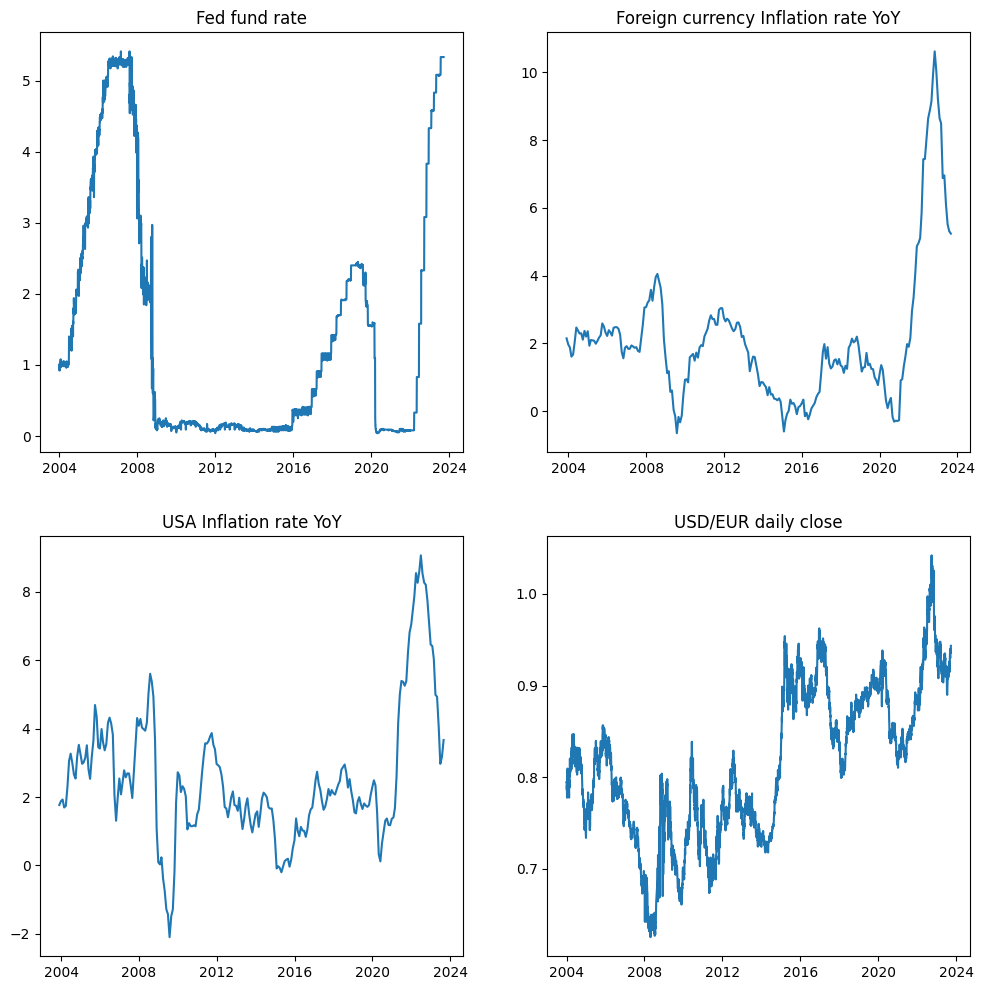

In [9]:
plt.figure(1)
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(12,12))
ax1.plot(fed_rates)
ax1.title.set_text('Fed fund rate')
ax2.plot(fccy_inflation_rate)
ax2.title.set_text('Foreign currency Inflation rate YoY')
ax3.plot(usa_inflation_rate)
ax3.title.set_text('USA Inflation rate YoY')
ax4.plot(hist['close'])
ax4.title.set_text('USD/' + ccy + ' daily close')
plt.show()

In [10]:
## Combine the data

hist.index = hist.index.date

combined = hist \
    .merge(fed_rates, how='outer', left_index=True, right_index=True, suffixes=(None, "_fed")) \
    .merge(usa_inflation_rate, how='outer', left_index=True, right_index=True, suffixes=(None, "_usa_inf")) \
    .merge(fccy_inflation_rate, how='outer', left_index=True, right_index=True, suffixes=(None, "_fccy_inf"))


# Data cleansing
---

Handle NA values in the dataset. 

Forward fill is used as the most meaningful value in time series (and financial market) is the "past observation"

In [11]:
combined.rename(columns={'Value':'fed_rate', 'Value_usa_inf':'usa_inf','Value_fccy_inf':'fccy_inf'}, inplace=True)
# forward-fill fields with no data
combined['fed_rate'].fillna(method='ffill', inplace=True)
combined['usa_inf'].fillna(method='ffill', inplace=True)
combined['fccy_inf'].fillna(method='ffill', inplace=True)
combined['relative_inf'] = combined['usa_inf']/combined['fccy_inf']



In [12]:
# Drop NA rows. This usually include the first few rows
df=combined.copy().dropna()
df

,open,high,low,close,volume,fed_rate,usa_inf,fccy_inf,relative_inf
2004-01-01,0.79428,0.80167,0.79315,0.79479,0.0,0.94,1.879,1.97,0.953807
2004-01-02,0.79479,0.79828,0.79189,0.79479,0.0,1.01,1.879,1.97,0.953807
2004-01-05,0.79120,0.79133,0.78777,0.78821,0.0,0.97,1.879,1.97,0.953807
2004-01-06,0.78808,0.78914,0.78076,0.78610,0.0,0.92,1.879,1.97,0.953807
2004-01-07,0.78592,0.79208,0.78493,0.79108,0.0,0.94,1.879,1.97,0.953807
...,...,...,...,...,...,...,...,...,...
2023-09-19,0.93522,0.93665,0.93290,0.93522,0.0,5.33,3.665,5.24,0.699427
2023-09-20,0.93615,0.93670,0.93223,0.93615,0.0,5.33,3.665,5.24,0.699427
2023-09-21,0.93870,0.94170,0.93689,0.93870,0.0,5.33,3.665,5.24,0.699427
2023-09-22,0.93795,0.94204,0.93707,0.93795,0.0,5.33,3.665,5.24,0.699427


# Feature extraction
---

- Technical indicators: 3 categories of technical indicators are included in the data set. They are often used by industry experts to predict stock/forex prices.
- **Candle stick** category contains 64 indicators. Prior experimentation shown that although it can improve RF slightly (R2 increase by ~0.02), it worsens LSTM apparently due to a lot of features and noice introduced

In [13]:
df.ta.strategy('momentum', append=True)
df.ta.strategy('trend', append=True)
df.ta.strategy('volatility', append=True)
df.ta.strategy('candles', append=True)

39it [00:02, 17.64it/s]
14it [00:01,  9.38it/s]
14it [00:01, 12.89it/s]
3it [00:01,  1.73it/s]


- Percentage change: the change in price compared with last 1 day and last 5 days

In [14]:
df['1d_delta'] = df['close'].pct_change(1)
df['5d_delta'] = df['close'].pct_change(5)



- remove columns with all NA values; fill NAs with forward fill; and drop NA rows (that corresponds to the first few rows which cannot be filled)

In [15]:
df = df.dropna(axis='columns', how='all').fillna(method='ffill').dropna()


- By shifting 1d_delta, I create `1d_future` which is going to be the Y values to be trained against

In [16]:
# the answer to be trained
df['1d_future'] = df['1d_delta'].shift(-1)
df.dropna(inplace=True)

- Standardize the data

In [17]:
## apply scaling
scaler = StandardScaler();
data = scaler.fit_transform(df)
data = pd.DataFrame(data, index=df.index, columns = df.columns)
data

,open,high,low,close,volume,fed_rate,usa_inf,fccy_inf,relative_inf,AO_5_34,...,high_Z_30_1,low_Z_30_1,close_Z_30_1,HA_open,HA_high,HA_low,HA_close,1d_delta,5d_delta,1d_future
2004-05-14,0.383547,0.135046,0.342821,0.316478,0.0,-0.245455,-0.139835,-0.025493,0.027225,0.240680,...,0.817699,0.939328,0.565602,0.304110,0.126926,0.353498,0.302893,-0.920042,-0.027164,-1.662523
2004-05-17,0.305047,0.101849,0.203189,0.195204,0.0,-0.228272,-0.139835,-0.025493,0.027225,0.189063,...,0.126486,-0.292481,-0.444543,0.318018,0.102128,0.213764,0.210092,-1.662146,-1.140528,0.925672
2004-05-18,0.195777,0.082800,0.220673,0.262686,0.0,-0.256910,-0.139835,-0.025493,0.027225,0.125244,...,-0.275863,-0.168708,0.079143,0.274192,0.083555,0.231261,0.194496,0.925996,-0.413506,-0.690199
2004-05-19,0.263253,0.080000,0.219824,0.212892,0.0,-0.256910,-0.139835,-0.025493,0.027225,0.072852,...,-0.374493,-0.228393,-0.423619,0.243745,0.072190,0.230411,0.196720,-0.689842,-0.637529,0.539684
2004-05-20,0.212616,0.095149,0.240830,0.252509,0.0,-0.256910,-0.139835,-0.025493,0.027225,0.022518,...,-0.096427,-0.086307,-0.085477,0.229739,0.087254,0.251432,0.207037,0.540016,-0.982130,-0.829042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18,1.476125,0.585812,1.483921,1.476521,0.0,2.223089,0.562657,1.525073,-0.093200,0.300771,...,1.099130,1.198051,1.244597,1.400113,0.575151,1.495425,1.294628,-0.412154,0.338769,-0.324576
2023-09-19,1.450201,0.577012,1.461580,1.450595,0.0,2.223089,0.562657,1.525073,-0.093200,0.300051,...,0.881836,0.973472,0.997564,1.408681,0.566401,1.473068,1.273511,-0.324227,0.393489,0.131679
2023-09-20,1.461467,0.577262,1.453445,1.461862,0.0,2.223089,0.562657,1.525073,-0.093200,0.302878,...,0.839634,0.858722,1.012946,1.401411,0.566650,1.464927,1.276834,0.132020,0.489546,0.372446
2023-09-21,1.492358,0.602260,1.510026,1.492756,0.0,2.223089,0.562657,1.525073,-0.093200,0.307065,...,1.240112,1.218712,1.170560,1.399594,0.591507,1.504203,1.316388,0.372781,0.561706,-0.117985


In [18]:
features = np.array(data.columns).tolist()
features.remove('1d_future')
features

['open',
 'high',
 'low',
 'close',
 'volume',
 'fed_rate',
 'usa_inf',
 'fccy_inf',
 'relative_inf',
 'AO_5_34',
 'APO_12_26',
 'BIAS_SMA_26',
 'BOP',
 'AR_26',
 'BR_26',
 'CCI_14_0.015',
 'CFO_9',
 'CG_10',
 'CMO_14',
 'COPC_11_14_10',
 'CTI_12',
 'ER_10',
 'BULLP_13',
 'BEARP_13',
 'FISHERT_9_1',
 'FISHERTs_9_1',
 'INERTIA_20_14',
 'K_9_3',
 'D_9_3',
 'J_9_3',
 'KST_10_15_20_30_10_10_10_15',
 'KSTs_9',
 'MACD_12_26_9',
 'MACDh_12_26_9',
 'MACDs_12_26_9',
 'MOM_10',
 'PGO_14',
 'PPO_12_26_9',
 'PPOh_12_26_9',
 'PPOs_12_26_9',
 'PSL_12',
 'QQE_14_5_4.236',
 'QQE_14_5_4.236_RSIMA',
 'QQEl_14_5_4.236',
 'QQEs_14_5_4.236',
 'ROC_10',
 'RSI_14',
 'RSX_14',
 'RVGI_14_4',
 'RVGIs_14_4',
 'SLOPE_1',
 'SMI_5_20_5',
 'SMIs_5_20_5',
 'SMIo_5_20_5',
 'SQZ_20_2.0_20_1.5',
 'SQZ_ON',
 'SQZ_OFF',
 'SQZ_NO',
 'SQZPRO_20_2.0_20_2_1.5_1',
 'SQZPRO_ON_WIDE',
 'SQZPRO_ON_NORMAL',
 'SQZPRO_ON_NARROW',
 'SQZPRO_OFF',
 'SQZPRO_NO',
 'STC_10_12_26_0.5',
 'STCmacd_10_12_26_0.5',
 'STCstoch_10_12_26_0.5',
 'S

# Random forest on 1d price change
---

Prepare the training and testing data for RF

In [28]:
# split data
x = data[features]
y = data['1d_future']


# In time series prediction, we are always faced with predicting the future instead of interpolating values
# Hence instead of randomly picking train/test data, we split it with a specific cutoff time
train_size = int(0.7 * y.shape[0])
x_train = x[:train_size]
y_train = y[:train_size]
x_test = x[train_size:]
y_test = y[train_size:]

## Hyper-Parameter tuning

Prior to using Grid search, I explore using different values of hyperparameters, one at a time, and plot train/test R2 scores. 

It is to look for a reasonble range to feed in Grid Search for every hyperparameter.

Reference: https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/

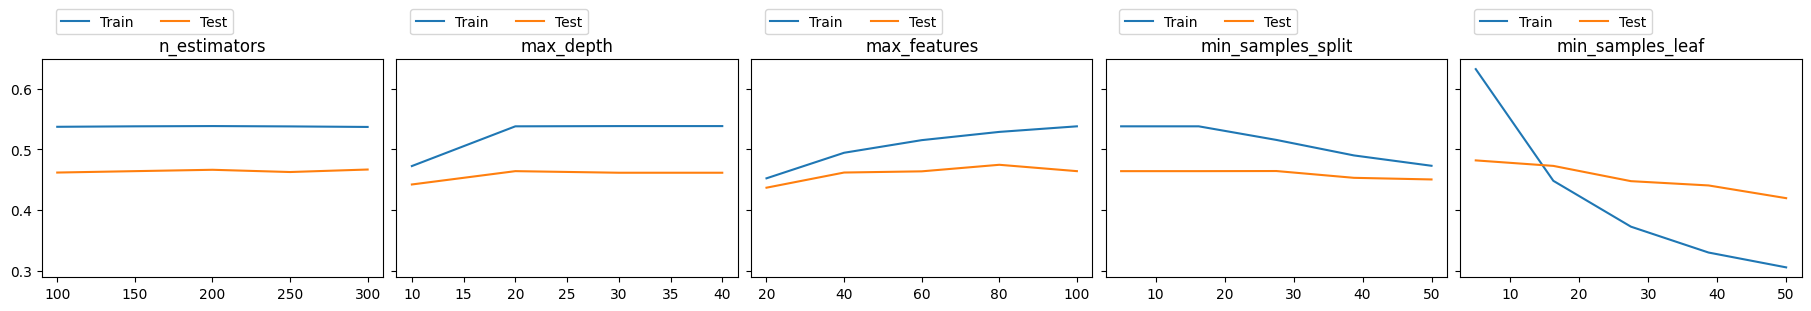

In [29]:


fig, axs = plt.subplots(ncols=5, figsize=(18,3), sharey=True, sharex=False, layout='constrained')
hyperparams = {
    'n_estimators': np.linspace(100, 300, 5),
    'max_depth': np.linspace(10,40,4),
    'max_features':np.linspace(20,100, 5),
    'min_samples_split' : np.linspace(5,50,5),
    'min_samples_leaf' : np.linspace(5,50,5)
}
i=0
for key, value in hyperparams.items():    
    train_score = []
    test_score = []
    for num in value:
         rf_model = RandomForestRegressor(n_estimators=150, max_depth=20, max_features=100, min_samples_split=20,  min_samples_leaf=10, random_state=42,)
         params = {key: int(num)}
         rf_model.set_params(**params)
         rf_model.fit(x_train, y_train)
         y_pred = rf_model.predict(x_test)
         train_score.append(rf_model.score(x_train, y_train))
         test_score.append(metrics.r2_score(y_test, y_pred))    
    
    axs[i].set_title(key)
    axs[i].plot(value, np.array(train_score), label='Train')
    axs[i].plot(value, np.array(test_score), label='Test')
    axs[i].legend(loc='lower left', bbox_to_anchor=(0,1.05), ncols=2, borderaxespad=1)
    i = i+1
plt.show()


Interpretations: 

- Apparently within the search range, `n_estimators`, `min_sample_split` and `max_depth` does not really affect the model accuracy
- `max_features` above 60 does not contribute much to accuracy
- With training R2 much higher than testing R2, a low `min_samples_leaf` could cause overfitting. 20 seems to be a good number.

**Perform Grid Search**

Find the best set of hyperparameters, reduce overfitting by using k-fold cross validation 

In [30]:
grid = {'n_estimators':[150], 'max_depth': [20, 30], 'max_features': [60,80,100], 'min_samples_split': [10,20], 'min_samples_leaf': [10,20], 'random_state': [42]}
test_scores = []

rf_model = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf_model, param_grid=grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


print("Best parameters: ", best_params)


Best parameters:  {'max_depth': 30, 'max_features': 100, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 150, 'random_state': 42}


## Predict and score

With the best model, predict y values and evaluate

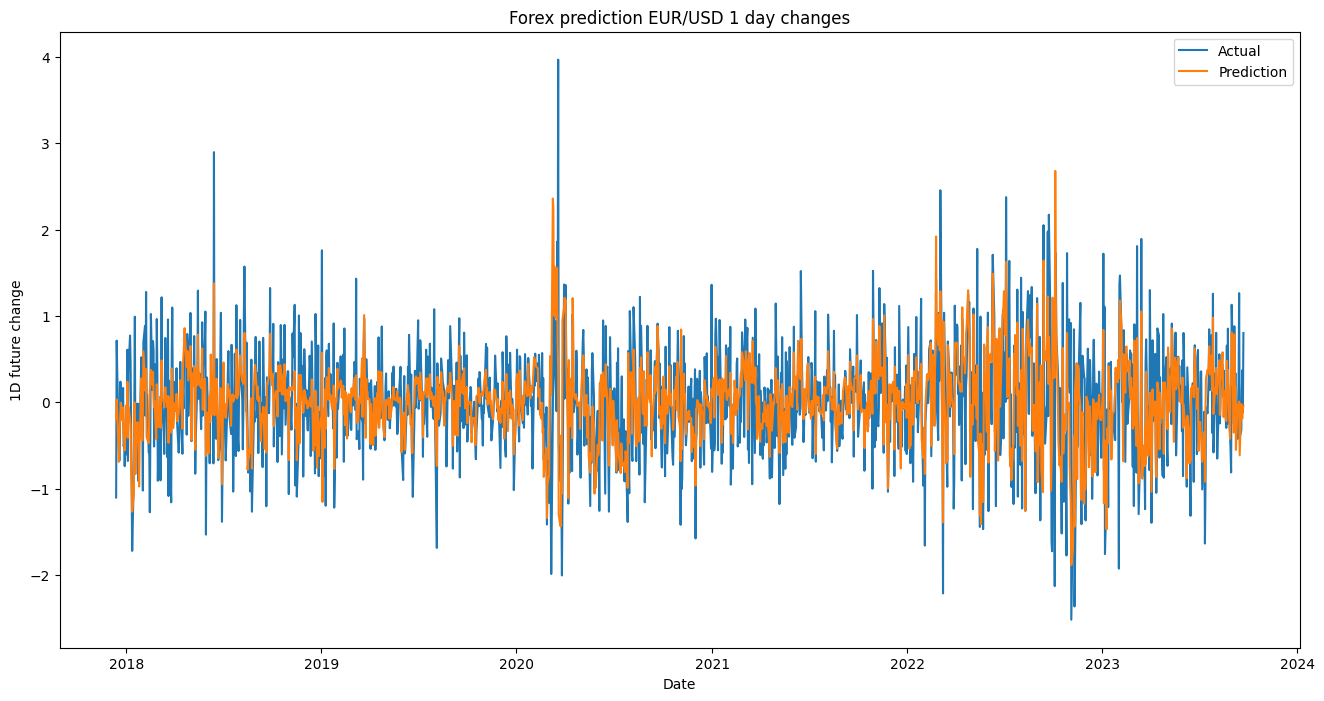

R2 on Training Set:  0.5382509881483974

R2 on Test Set:  0.46149308140454526
Mean Absolute Error: 0.33663442692483225
Mean Squared Error: 0.21744513000928023
Root Mean Squared Error: 0.4663101221389905


In [31]:
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)
y_pred_series = pd.Series(y_pred, index= y_test.index)
y_test_series = pd.Series(y_test, index= y_test.index)

plt.figure(figsize=(16,8))
plt.title("Forex prediction " + ccy + "/USD 1 day changes")
plt.xlabel("Date")
plt.ylabel("1D future change")
plt.plot(y_test_series)
plt.plot(y_pred_series)
plt.legend(['Actual', 'Prediction'])

plt.show()
print('R2 on Training Set: ', best_model.score(x_train, y_train))
print()
print('R2 on Test Set: ',  metrics.r2_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
compare['RF-PD-CHNG'] = ['Next Day Price change', 'Random Forest', metrics.r2_score(y_test, y_pred) ,metrics.mean_absolute_error(y_test, y_pred),metrics.mean_squared_error(y_test, y_pred),np.sqrt(metrics.mean_squared_error(y_test, y_pred))]


In [32]:
feat_imprt = pd.DataFrame(best_model.feature_importances_, columns=['Importance'])
feat_imprt['feat'] = np.array(features)
print('Top 20 important features')
feat_imprt.sort_values(by='Importance', ascending=False)[:20]

Top 20 important features


,Importance,feat
90,0.301704,DPO_20
22,0.046824,BULLP_13
125,0.044300,PDIST
131,0.038725,TRUERANGE_1
23,0.031750,BEARP_13
127,0.027907,THERMO_20_2_0.5
150,0.024536,CDL_DRAGONFLYDOJI
155,0.024528,CDL_GRAVESTONEDOJI
50,0.019208,SLOPE_1
188,0.016544,CDL_TAKURI


# LSTM on 1d price change
---

## Setup

In [19]:
## Setup
time_steps = 10
train_percentage = 0.8

## Workaround suggested in https://github.com/scikit-optimize/scikit-optimize/issues/1138
np.int = int

## Define a wrapper class for parameter tuning
class BaseLSTMModel(BaseEstimator):
    def __init__(self, units_layer1=50, units_layer2=0, dropout_rate=0.2, batch_size = 32, activation='relu', epoch=25, validation_split=0, verbose=0):
        self.units_layer1 = units_layer1
        self.units_layer2 = units_layer2
        self.dropout_rate = dropout_rate
        self.batch_size = batch_size
        self.activation = activation
        self.validation_split = validation_split
        self.epoch = epoch
        self.verbose = verbose
    
    def fit(self, X, y):       
        self.model = Sequential()
        if (self.units_layer2 > 0):
            self.model.add(LSTM(self.units_layer1, self.activation, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
            self.model.add(LSTM(self.units_layer2, self.activation, return_sequences=False))
        else:
            self.model.add(LSTM(self.units_layer1, self.activation, input_shape=(X.shape[1], X.shape[2]), return_sequences=False))
        self.model.add(Dropout(self.dropout_rate))
        self.model.add(Dense(1))
        self.model.compile(loss='mean_squared_error', optimizer='adam') 
        return self.model.fit(X, y, epochs=self.epoch, batch_size=self.batch_size, verbose=self.verbose, shuffle=False, validation_split=self.validation_split)
        

    def predict(self, X):
        return self.model.predict(X)
    
    def summary(self):
        self.model.summary()

In [20]:
## features_for_price_change = np.array(feat_imprt.sort_values(by='Importance', ascending=False)[:50]['feat']).tolist()
features_for_price_change = features.copy()

In [21]:
## Reshape input data into n samples of sequences
## Each has a X value corresponding to the past 10 days of data with 20 features
## and a Y value corresponding to the next day closing price


print('Shape of data: ', data.shape)
train_size = int(train_percentage * data.shape[0])
train_data = data[:train_size]
train_data_features = train_data[features_for_price_change].values
train_delta = train_data[['1d_future']].values

x = []
y = []
for i in range(time_steps, len(train_data_features)):
    x.append(train_data_features[i - time_steps: i, 0:train_data_features.shape[1]])
    y.append(train_delta[i-1:i, 0])

x_train, y_train = np.array(x), np.array(y)

print('Shape of x_train', x_train.shape)
print('Shape of y_train', y_train.shape)


test_data = data[train_size:]
test_data_features = test_data[features_for_price_change].values
test_delta = test_data[['1d_future']].values
x_test = []
y_test = []
for i in range(time_steps, len(test_data_features)):
    x_test.append(test_data_features[i - time_steps: i, 0: test_data_features.shape[1]])
    y_test.append(test_delta[i-1:i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
print('Shape of x_test', x_test.shape)
print('Shape of y_test', y_test.shape)

Shape of data:  (5022, 206)
Shape of x_train (4007, 10, 205)
Shape of y_train (4007, 1)
Shape of x_test (995, 10, 205)
Shape of y_test (995, 1)


## Model tuning

In [22]:
## Caution: This runs a LONG time

## Model tuning using Bayesian Search
## Due to the large parameter space and computational resource constraint, the search itself is an iterative process. 
## By examining the output score I can refine the range for each variable to search.
lstm_model = BaseLSTMModel()
param_space = {
    'units_layer1' : Integer(16, 200, prior='log-uniform'),
    'dropout_rate' : Real(0.2, 0.5, prior='uniform'),
    'batch_size' : Integer(8, 32, prior='uniform'),
    'epoch' : Integer(10,50, prior='uniform'),
    'activation' : ['sigmoid']
}

tscv = TimeSeriesSplit(n_splits=3)
opt = BayesSearchCV(estimator=lstm_model, search_spaces=param_space, cv=tscv, n_iter=30, n_jobs=-1, scoring='neg_mean_squared_error', verbose=3, random_state=42 )
opt.fit(x_train, y_train)

print('Best hyperparameters:' , opt.best_params_)
print('Best negative MSE: ', opt.best_score_)
opt.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
32/32 [==============================] - 1s 13ms/step
[CV 1/3] END activation=sigmoid, batch_size=25, dropout_rate=0.4798603996543502, epoch=23, units_layer1=87;, score=-2.169 total time=  22.0s
32/32 [==============================] - 1s 12ms/step
[CV 2/3] END activation=sigmoid, batch_size=25, dropout_rate=0.4798603996543502, epoch=23, units_layer1=87;, score=-0.580 total time=  44.1s
32/32 [==============================] - 1s 17ms/step
[CV 3/3] END activation=sigmoid, batch_size=25, dropout_rate=0.4798603996543502, epoch=23, units_layer1=87;, score=-0.237 total time= 1.1min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
32/32 [==============================] - 1s 16ms/step
[CV 1/3] END activation=sigmoid, batch_size=29, dropout_rate=0.2910230329652525, epoch=48, units_layer1=142;, score=-2.174 total time=  57.4s
32/32 [==============================] - 1s 17ms/step
[CV 2/3] END activation=sigmoid, batch_size=29,

BaseLSTMModel(activation='sigmoid', dropout_rate=0.297424546861563, epoch=14,
              units_layer1=200)

## Examine Loss Plot

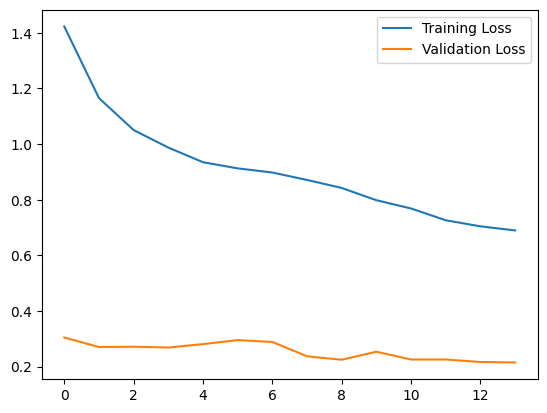

In [23]:
lstm = BaseLSTMModel(**opt.best_params_, validation_split=0.2)
history = lstm.fit(x_train, y_train)
plt.plot(history.history.get('loss'), label='Training Loss')
plt.plot(history.history.get('val_loss'), label='Validation Loss')
plt.legend()


In [24]:
## Re-fit with the full training set. Make prediction and scoring

lstm = BaseLSTMModel(**opt.best_params_)
history = lstm.fit(x_train, y_train)
predictions = lstm.predict(x_test)
print('R2 on Test Set: ',  metrics.r2_score(y_test, predictions))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

compare['LSTM-PD-CHNG'] = ['Next Day Price change', 'Long Short Term Memory', metrics.r2_score(y_test, predictions) ,metrics.mean_absolute_error(y_test, predictions),metrics.mean_squared_error(y_test, predictions),np.sqrt(metrics.mean_squared_error(y_test, predictions))]

32/32 [==============================] - 1s 15ms/step
R2 on Test Set:  0.4692383339358033
Mean Absolute Error: 0.36284805702296813
Mean Squared Error: 0.24241802389942088
Root Mean Squared Error: 0.4923596489350248


In [25]:
## Inverse transform the predictions to get predicted value of 1d_future
index_1d_future = test_data.columns.get_loc('1d_future')
result = scaler.inverse_transform(test_data)
result = pd.DataFrame(result, index=test_data.index, columns = test_data.columns)
inverse_scaler = StandardScaler()
inverse_scaler.mean_=[scaler.mean_[index_1d_future]]
inverse_scaler.scale_=[scaler.scale_[index_1d_future]]
predicted_changes = inverse_scaler.inverse_transform(predictions)
result = result[time_steps:].copy()
result['Prediction'] = predicted_changes


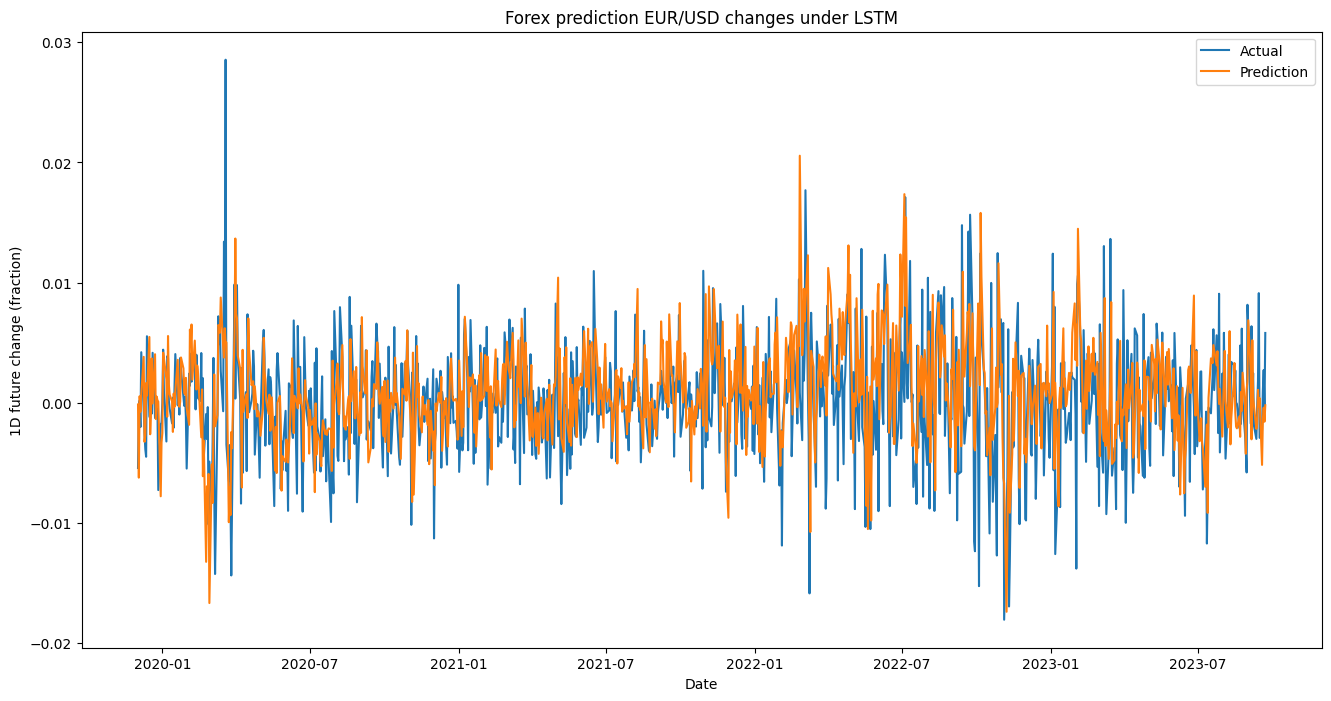

In [38]:
plt.figure(figsize=(16,8))
plt.title("Forex prediction "+ ccy + "/USD changes under LSTM")
plt.xlabel("Date")
plt.ylabel("1D future change (fraction)")
plt.plot(result['1d_future'])
plt.plot(result['Prediction'])
plt.legend(['Actual', 'Prediction'])
plt.show()

# Overall evaluation

In [33]:
compare

,item,LSTM-PD-CHNG,RF-PD-CHNG
0,Goal,Next Day Price change,Next Day Price change
1,Model,Long Short Term Memory,Random Forest
2,R2-Test,0.469238,0.461493
3,Mean Absolute Error,0.362848,0.336634
4,Mean Squared Error,0.242418,0.217445
5,Root Mean Squared Error,0.49236,0.46631
